In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mir_eval
import IPython.display

from clusterer import Clusterer
from visualizers import vis_spec

/Users/carlos/.local/share/virtualenvs/audio-repair-k6vkcEgJ/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/carlos/.local/share/virtualenvs/audio-repair-k6vkcEgJ/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Ground-Truth

Load checkpoints

In [2]:
def load_checkpoint(path:str) -> np.ndarray:
    arr:np.ndarray = None
    with open(path, 'rb') as f:
        arr = np.load(f)
    return arr

In [3]:
# G_full:np.ndarray = load_checkpoint('checkpoints/G_full.pkl')
G_foreground:np.ndarray = load_checkpoint('checkpoints/G_foreground.pkl')
G_fg_mask:np.ndarray = load_checkpoint('checkpoints/G_fg_mask.pkl')
    
print(G_foreground[:2])
print(G_foreground.shape)

[[6.3289583e-05 5.2768064e-05 3.5819125e-05 ... 2.3706085e-05
  2.0665200e-05 7.2684639e-07]
 [7.3489988e-05 4.5792454e-05 3.1348951e-05 ... 3.6043770e-05
  1.3170381e-04 3.3057091e-05]]
(128, 1056)


Initialize clusterer

In [4]:
G_clusterer:Clusterer = Clusterer(G_foreground.T, [f'm-{i}' for i in range(0,128)])

Preview features

In [5]:
G_df = pd.DataFrame(G_foreground.T, columns=[f'm-{i}' for i in range(0,128)])
G_df[:2].head()

,m-0,m-1,m-2,m-3,m-4,m-5,m-6,m-7,m-8,m-9,...,m-118,m-119,m-120,m-121,m-122,m-123,m-124,m-125,m-126,m-127
0,0.000063,0.000073,0.000157,0.000192,0.000154,0.000270,0.000071,0.000093,0.000212,0.000099,...,2.216481e-07,3.430721e-07,3.311074e-07,3.448311e-07,6.898240e-07,7.069977e-07,0.000001,0.000001,7.092929e-07,0.000001
1,0.000053,0.000046,0.000099,0.000074,0.000230,0.000584,0.000341,0.000083,0.000063,0.000080,...,1.770649e-07,3.787884e-07,2.929955e-07,4.247919e-07,5.063856e-07,9.536089e-07,0.000001,0.000001,1.190853e-06,0.000001


Establish K with Kmeans

In [6]:
def search_param(method:callable, key:str, mn:int=2, mx:int=9, params:dict={}) -> int:
    ks:list = []
    for k in range(mn, mx):
        try:
            params.update({key: k})
            sil_score = method(params)
            ks.append((k, sil_score))
            # print((k, sil_score))
        except:
            break
    
    best:list = sorted(ks, key=lambda tup: tup[1], reverse=True)
    
    val, _ = best[0]
    
    #print('best: ', _, val)
    
    return val

In [7]:
G_k = search_param(G_clusterer.apply_kmeans, 'n_clusters', mn=2, mx=20)
G_km_SilScore = G_clusterer.apply_kmeans({'n_clusters': G_k})
G_kmeans = G_clusterer.kmeans
G_km_labels:list = G_kmeans.labels_
    
print('Labels:', np.unique(G_km_labels, return_counts=True))
print('Silhouette Score:', G_km_SilScore)
print('Best K:', G_k)

Labels: (array([0, 1], dtype=int32), array([146, 910]))
Silhouette Score: 0.66730756
Best K: 2


In [592]:
def vis_clusters(original, 
                 clusters:list, 
                 xlim:tuple=(-1,1), 
                 ylim:tuple=(-1,1),
                 title:str='',
                 colors:list=None,
                 split:bool=False,
                 split_titles:list=None):
    
    colors:list = colors or ['c','m','b', 'g', 'r', 'y', 'k', 'w']
    
    if split:
        fig, axs = plt.subplots(1,len(clusters), figsize=(15, 3), facecolor='w', edgecolor='k')
        fig.subplots_adjust(hspace =.5, wspace=.5)
        axs = axs.ravel()
    
    for i, cl in enumerate(clusters):   
        
        obj = axs[i] if split else plt
        obj.scatter(original[cl][:, 0], original[cl][:, 1], s=50, c=colors[i], alpha=.25);
        
        if split:
            obj.set_xlim(*xlim)
            obj.set_ylim(*ylim)
            if split_titles and len(split_titles) == len(clusters):
                obj.set_title(split_titles[i])
        else:
            plt.xlim(*xlim)
            plt.ylim(*ylim)
    
    if not split:
        plt.title(title)

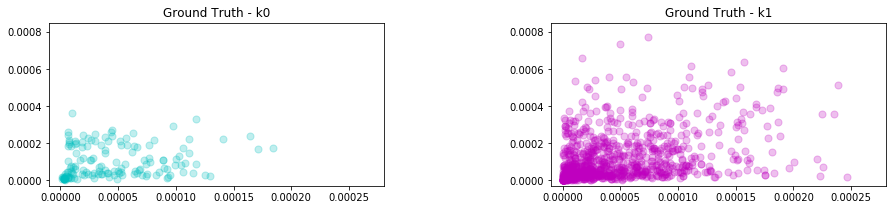

In [593]:
G_primary_cluster:np.ndarray = np.where(G_km_labels == 0)[0]
G_secondary_cluster:np.ndarray = np.where(G_km_labels == 1)[0]

G_clusters:list = [
    G_primary_cluster,
    G_secondary_cluster
]

vis_clusters(G_foreground.T, 
             G_clusters, 
             xlim=(-.00001, .00028),
             ylim=(-.00003, .00085),
             split_titles=['Ground Truth - k0', 'Ground Truth - k1'],
             split=True)

Find outliers with DBSCAN

In [9]:
G_min_cluster_size:int = search_param(G_clusterer.apply_hdbscan, 
                                      'min_cluster_size', 
                                       mn=2, mx=100, 
                                       params={})

In [10]:
G_min_samples:int = search_param(G_clusterer.apply_hdbscan,
                                 'min_samples', 
                                 mn=2, mx=100,
                                 params={'min_cluster_size': G_min_cluster_size})

Since hdbscan supports sparse clusters, we should expect to arrive at more than 2

In [11]:
G_hdb_SilScore:float = G_clusterer.apply_hdbscan({ # euclidean distance
    'min_cluster_size':G_min_cluster_size,
    'min_samples': G_min_samples,
    'allow_single_cluster': True
})
G_hdb_labels:tuple = G_clusterer.hdbscan.labels_
print('Best K:', len(np.unique(G_hdb_labels)))
print('Optimal min_cluster_size:', G_min_cluster_size)
print('Optimal min_samples:', G_min_samples)
print('Labels:', np.unique(G_hdb_labels, return_counts=True))
print('Silhouette Score:', G_hdb_SilScore)

Best K: 3
Optimal min_cluster_size: 55
Optimal min_samples: 49
Labels: (array([-1,  0,  1]), array([170, 813,  73]))
Silhouette Score: 0.5319491


HDBSCAN Clusters

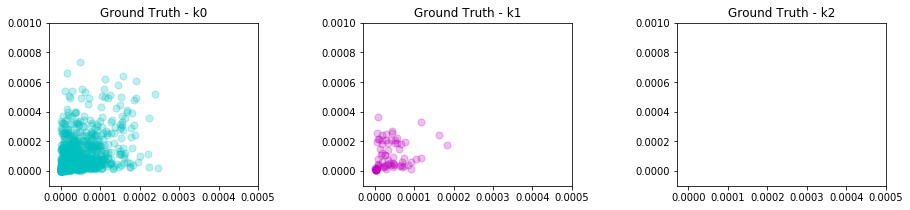

In [617]:
G_1_cluster:np.ndarray = np.where(G_hdb_labels == 0)[0]
G_2_cluster:np.ndarray = np.where(G_hdb_labels == 1)[0]
G_3_cluster:np.ndarray = np.where(G_hdb_labels == 2)[0]

G_clusters:list = [
    G_1_cluster,
    G_2_cluster,
    G_3_cluster,
]

vis_clusters(G_foreground.T, 
             G_clusters,
             xlim=(-.00003, .0005),
             ylim=(-.0001, .001),
             split_titles=['Ground Truth - k0', 'Ground Truth - k1', 'Ground Truth - k2'],
             split=True,)

Establish baseline for outliers

In [12]:
G_outlier_scores:np.ndarray = G_clusterer.hdbscan.outlier_scores_
G_outlier_scores[:5]

array([0.04902951, 0.05063146, 0.05247493, 0.04460207, 0.        ])

Text(0.5, 1.0, 'Outliers Distribution - Ground Truth')

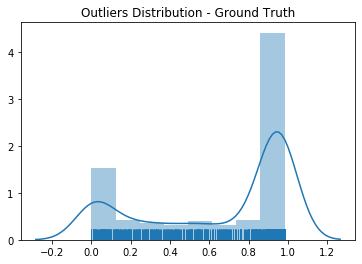

In [424]:
sns.distplot(G_outlier_scores[np.isfinite(G_outlier_scores)], 
             rug=True,)
plt.title("Outliers Distribution - Ground Truth")

In [15]:
G_threshold:np.ndarray = pd.Series(G_outlier_scores).quantile(.9)
G_outliers:np.ndarray = np.where(G_outlier_scores > G_threshold)[0]
print(f'Total Scores > {G_threshold} = {len(G_outliers)}')

Total Scores > 0.973784851805894 = 106


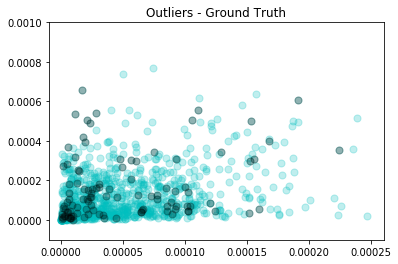

In [425]:
G_fg_bool:np.ndarray = np.ones(G_outlier_scores.shape, dtype=bool)
vis_clusters(G_foreground.T, [G_fg_bool, G_outliers],
             xlim=(-.00001, .00026),
             ylim=(-.0001, .001),
             title='Outliers - Ground Truth',
             colors=['c','k'])

In [17]:
def reconstruct_from_indices(Mel, indices):
    return Mel.T[np.where(indices >= indices.min())].T

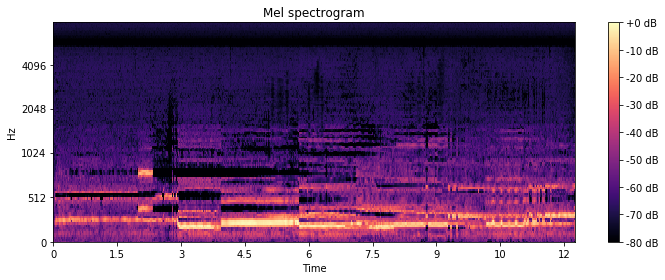

In [357]:
G_outlier_indices = np.where(G_outlier_scores >= G_outlier_scores.min())[0]
G_label_indices = np.where(G_hdb_labels >= G_hdb_labels.min())[0]

G_outliers_mel = reconstruct_from_indices(G_foreground, G_outlier_indices)

vis_spec(G_outliers_mel)

In [378]:
def audio_to_onset(audio, sr) -> tuple:
    frames:np.ndarray = librosa.onset.onset_detect(audio, sr=sr, delta=0., wait=10)
    times:np.ndarray = librosa.frames_to_time(frames, sr=sr)
    samples:np.ndarray = librosa.frames_to_samples(frames)
        
    return (frames, times, samples)

In [ ]:
sr:int = 44100
G_audio:np.ndarray = librosa.feature.inverse.mel_to_audio(G_foreground/G_fg_mask, sr=sr)

In [379]:
_, G_onset_times, _ = audio_to_onset(G_audio, sr=sr)

In [380]:
G_with_beeps = mir_eval.sonify.clicks(G_onset_times, sr)

In [384]:
IPython.display.Audio(G_with_beeps, rate=sr)

# Damaged

In [344]:
D_foreground:np.ndarray = load_checkpoint('checkpoints/D_foreground.pkl')
D_fg_mask:np.ndarray = load_checkpoint('checkpoints/D_fg_mask.pkl')

print(D_foreground[:2])
print(D_foreground.shape)

[[0.00364477 0.00130424 0.00304495 ... 0.01756942 0.01682045 0.00175911]
 [0.02037755 0.00958439 0.00574314 ... 0.06446123 0.05637852 0.01214198]]
(128, 1056)


Initialize clusterer

In [246]:
D_clusterer:Clusterer = Clusterer(D_foreground.T, [f'm-{i}' for i in range(0,128)])

In [247]:
D_k = search_param(D_clusterer.apply_kmeans, 'n_clusters', mn=2, mx=20,)
D_km_SilScore = D_clusterer.apply_kmeans({'n_clusters': D_k})
D_kmeans = D_clusterer.kmeans
D_km_labels:list = D_kmeans.labels_
    
print('labels:', np.unique(D_km_labels, return_counts=True))
print('silhouette score:', D_km_SilScore)
print('Best K:', D_k)

labels: (array([0, 1, 2], dtype=int32), array([167, 722, 167]))
silhouette score: 0.6328212
Best K: 3


K-Means Clusters

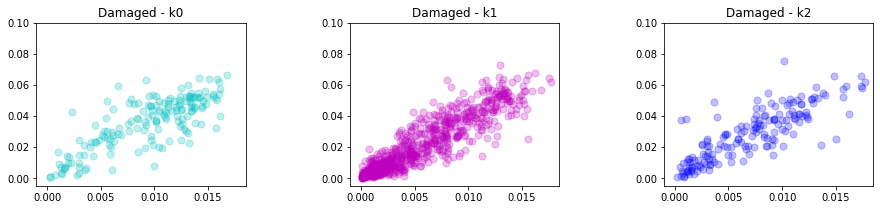

In [601]:
D_1_cluster:np.ndarray = np.where(D_km_labels == 0)[0]
D_2_cluster:np.ndarray = np.where(D_km_labels == 1)[0]
D_3_cluster:np.ndarray = np.where(D_km_labels == 2)[0]

D_clusters:list = [
    D_1_cluster,
    D_2_cluster,
    D_3_cluster,
]

# print(D_foreground.T.min(), D_foreground.T.max())

vis_clusters(D_foreground.T, 
             D_clusters,
             xlim=(-.001, .0185),
             ylim=(-.005, .1),
             split_titles=['Damaged - k0', 'Damaged - k1', 'Damaged - k2'],
             split=True,)

Find outliers with DBSCAN

In [294]:
D_min_cluster_size:int = search_param(D_clusterer.apply_hdbscan, 
                                      'min_cluster_size', 
                                       mn=2, mx=100, 
                                       params={})

In [295]:
D_min_samples:int = search_param(D_clusterer.apply_hdbscan,
                                 'min_samples', 
                                 mn=2, mx=100,
                                 params={'min_cluster_size': D_min_cluster_size})

In [296]:
D_hdb_SilScore:float = D_clusterer.apply_hdbscan({ # euclidean distance
    'min_cluster_size':D_min_cluster_size,
    'min_samples': D_min_samples,
    'allow_single_cluster': True
})
D_hdb_labels:tuple = D_clusterer.hdbscan.labels_
print('Best K:', len(np.unique(D_hdb_labels)))
print('Optimal min_cluster_size:', D_min_cluster_size)
print('Optimal min_samples:', D_min_samples)
print('Labels:', np.unique(D_hdb_labels, return_counts=True))
print('Silhouette Score:', D_hdb_SilScore)

Best K: 3
Optimal min_cluster_size: 16
Optimal min_samples: 72
Labels: (array([-1,  0,  1]), array([248, 783,  25]))
Silhouette Score: 0.43325943


HBDSCAN Clusters

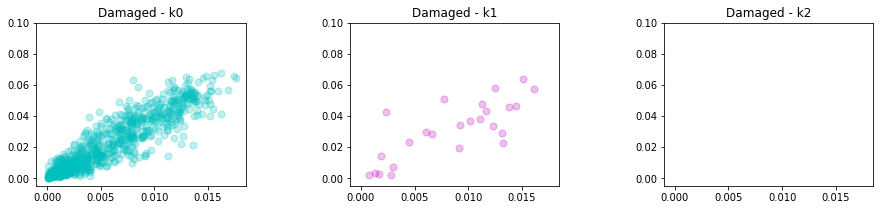

In [598]:
D_1_cluster:np.ndarray = np.where(D_hdb_labels == 0)[0]
D_2_cluster:np.ndarray = np.where(D_hdb_labels == 1)[0]
D_3_cluster:np.ndarray = np.where(D_hdb_labels == 2)[0]

D_clusters:list = [
    D_1_cluster,
    D_2_cluster,
    D_3_cluster,
]

# print(D_foreground.T.min(), D_foreground.T.max())

vis_clusters(D_foreground.T, 
             D_clusters,
             xlim=(-.001, .0185),
             ylim=(-.005, .1),
             split_titles=['Damaged - k0', 'Damaged - k1', 'Damaged - k2'],
             split=True,)

In [297]:
D_outlier_scores:np.ndarray = D_clusterer.hdbscan.outlier_scores_
D_outlier_scores[:5]

array([0.        , 0.        , 0.01869727, 0.        , 0.00594683])

Text(0.5, 1.0, 'Outliers Distribution - Damaged Sample')

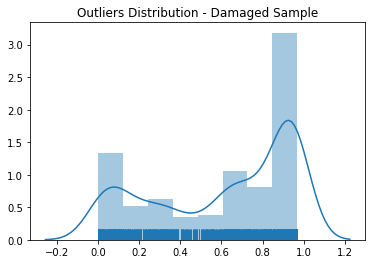

In [427]:
sns.distplot(D_outlier_scores[np.isfinite(D_outlier_scores)], 
             rug=True,)
plt.title("Outliers Distribution - Damaged Sample")

In [304]:
D_threshold:np.ndarray = pd.Series(D_outlier_scores).quantile(.9)
D_outliers:np.ndarray = np.where(D_outlier_scores > D_threshold)[0]
print(f'Total Scores > {D_threshold} = {len(D_outliers)}')

Total Scores > 0.9584192660547244 = 106


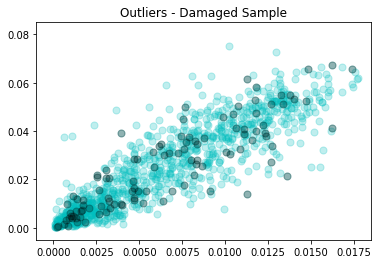

In [428]:
all_foreground:np.ndarray = np.ones(D_outlier_scores.shape, dtype=bool)
vis_clusters(D_foreground.T, [all_foreground, D_outliers],
             xlim=(-.001, .0185),
             ylim=(-.005, .085),
             title='Outliers - Damaged Sample',
             colors=['c','k'])

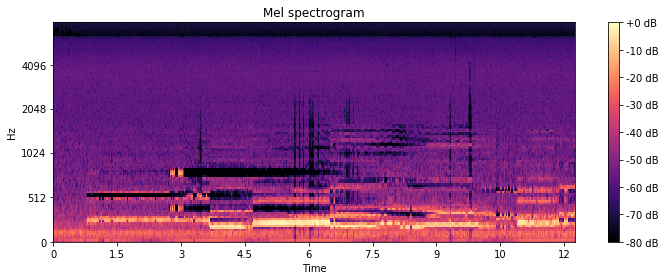

In [356]:
D_outlier_indices = np.where(D_outlier_scores >= D_outlier_scores.min())[0]
D_label_indices = np.where(D_hdb_labels >= D_hdb_labels.min())[0]

# make sure we can reconstruct
D_outliers_mel = reconstruct_from_indices(D_foreground, D_outlier_indices)

vis_spec(D_outliers_mel)

In [358]:
sr:int = 44100

In [387]:
D_audio = librosa.feature.inverse.mel_to_audio(D_foreground/D_fg_mask, sr=sr)

In [388]:
# TODO onsets
_, D_onset_times, _ = audio_to_onset(D_audio, sr=sr)
D_with_beeps = mir_eval.sonify.clicks(D_onset_times, sr)

In [397]:
# D_outliers_masked = D_foreground.T[D_outlier_indices].T/D_fg_mask
D_outliers_audio = librosa.feature.inverse.mel_to_audio(D_outliers_mel/D_fg_mask, sr=sr)

In [399]:
IPython.display.Audio( D_outliers_audio, rate=sr)